In [15]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

# Load functions to load data and make decision trees
%run ./load_nc_and_subset.ipynb
%run ./DecisionTree.ipynb

warnings.simplefilter('ignore') # Ignore warnings. 

In [16]:
# Function to create and train a random forest
def RandomForestTrain(x, y, attributes, max_depth = 5, multiplier = 1, n_trees = 100, 
                      decorr_n = None):
    '''
    Input:
    x - Training examples. x is a m x n matrix, with n examples and m  features
    y - Labels, or target values. Currently only binary 0 or 1 (or -1 and 1) allowed. Must be a vector of size m
    attributes: List of numerical values to compare the training examples to. Currently, only a v x m array of 
                numerical values are accepted.
    max_depth: Default = 5. Maxmium depth of the tree
    multiplier: A constant to help better classify extreme cases. For the most common scenario, the most common is
                (multipler * positive cases) compared to (negative cases)
    n_trees: Number of trees in the forest.
    decorr_n: Number of attributes used in each tree (to decorrelate each tree)
    
    Output:
    RandomForest - The random forest model. A list containing n_trees trees
    '''
    
    # Since a random sample is chosen, maximize the use of each sample by removing the nans
    ind = np.where(np.isnan(y))[0]
    
    M, N = x.shape
    x_new = np.zeros((M, N))
    y_new = np.zeros((M))
    
    x_new = x
    y_new = y
    
    x_new = np.delete(x_new, ind, axis = 0)
    y_new = np.delete(y_new, ind, axis = 0)
    
    # If decorr_n is none, default it to sqrt(N)
    if decorr_n == None:
        decorr_n = np.floor(np.sqrt(N)).astype(int)
    else:
        decorr_n = decorr_n
        
    # Initialize the forest
    #RandomForest = np.asarray([[None, None]])
    RandomForest = []
    
    # Get the new sample size
    M, N = x_new.shape
    V, N = attributes.shape
    
    # Begin growing the forest
    for t in range(n_trees):
        # Draw the random sample with replacement of size M
        ind = np.random.choice(np.arange(M), size = M, replace = True).astype(int)
        x_sample = x_new[ind, :]
        y_sample = y_new[ind]
        
        # Choice the random attribute for this tree. Do not repeat attributes (repalce = False)
        ind = np.random.choice(np.arange(N), size = decorr_n, replace = False).astype(int)
        attributes_sample = np.zeros((V, N)) * np.nan
        attributes_sample[:,ind] = attributes[:,ind]
        
        # Note the best variable/split is already chosen in the decision tree training function, so the final
        # two steps (ii and iii) in algorithm 15.1 are fulfilled in there.
        
        # Grow the tree
        tree = DecisionTreeTrain(x_sample, y_sample, attributes_sample, max_depth = max_depth, multiplier = multiplier)
        
        # Append the tree to the forest
        RandomForest.append(tree)
        #RandomForest = np.append(RandomForest, tree, axis = 0)
        
        #if t == 0:
        #    RandomForest = np.delete(RandomForest, 0, axis = 0) # Remove the empty initial value in Random Forest, now that it has a tree to build off of
        
    return RandomForest


# Function to make predictions using a random forest
def RandomForestPredict(RandomForest, x, attributes, n_trees, P_crit = 0.5):
    '''
    Input:
    RandomForest - The random forest model. A list containing n_trees trees
    x - Training examples. x is a m x n matrix, with n examples and m  features
    attributes: List of numerical values to compare the training examples to. Currently, only a v x m array of 
                numerical values are accepted.
    n_trees: Number of trees in the forest.
    P_crit - The probability threshold for P_pos above which the prediction yhat is made positive
    
    Output:
    yhat - Predicted labels using the random forest. 1 x m size array
    P_pos - Probability of the predicted label being positive. 1 x m size array
    P_neg - Probability of the predicted label being negative. 1 x m size array
    '''
    
    # Collect the sample size
    M, N = x.shape
    
    # Initialize the some of the target variables
    P_pos_array = np.zeros((n_trees, M))
    P_neg_array = np.zeros((n_trees, M))
    yhat_array  = np.zeros((n_trees, M))
    
    # Loop over all trees in the forest
    for t in range(n_trees):
        # Find the target values for the given tree
        tree = RandomForest[t]
        yhat_array[t,:], P_pos_array[t,:], P_neg_array[t,:] = DecisionTreePredict(tree, x, attributes, P_crit = P_crit)
        
    # For the probabilities, the probability values of the forest should be the mean of probabilities
    # The predicted classification is the majority vote
    yhat = np.zeros((M)) * np.nan
    for m in range(M):
        majority_vote = 1 if np.sum(yhat_array[:,m] == 1) > np.sum(yhat_array[:,m] == -1) else -1
        yhat[m] = majority_vote
        
    P_pos = np.nanmean(P_pos_array, axis = 0)
    P_neg = np.nanmean(P_neg_array, axis = 0)
        
    return yhat, P_pos, P_neg


In [17]:
# Function to create and train a boosted ensemble model
def AdaBoostTrain(x, y, attributes, max_depth = 1, multiplier = 1, n_stumps = 100,
                 val = False, x_val = None):
    '''
    Input:
    x - Training examples. x is a m x n matrix, with n examples and m  features
    y - Labels, or target values. Currently only binary 0 or 1 (or -1 and 1) allowed. Must be a vector of size m
    attributes: List of numerical values to compare the training examples to. Currently, only a v x m array of 
                numerical values are accepted.
    max_depth: Default = 5. Maxmium depth of the tree
    multiplier: A constant to help better classify extreme cases. For the most common scenario, the most common is
                (multipler * positive cases) compared to (negative cases)
    n_trees: Number of trees in the forest.
    decorr_n: Number of attributes used in each tree (to decorrelate each tree)
    
    Output:
    yhat - Predicted labels using the Ada Boosted Model. 1 x m size array
    P_pos - Probability of the predicted label being positive. 1 x m size array
    P_neg - Probability of the predicted label being negative. 1 x m size array
    '''
    
    # Get the size of the sample
    M, N = x.shape
    
    # Initialize the weights
    w = np.zeros((N))
    w[:] = 1/N
    
    # Initialize the risk, and predicted values
    Rd = np.zeros((N))
    yhat_model = np.zeros((M, n_stumps))
    P_pos_model = np.zeros((M, n_stumps))
    P_neg_model = np.zeros((M, n_stumps))
    
    x_weighted = np.zeros((M, N))
    
    if val == True:
        M_val, N = x_val.shape
        
        yhat_model_val = np.zeros((M_val, n_stumps))
        P_pos_model_val = np.zeros((M_val, n_stumps))
        P_neg_model_val = np.zeros((M_val, n_stumps))
        
        x_val_weighted = np.zeros((M_val, N))
    
    # Loop over all stumps
    for ns in range(n_stumps):
        # Induce the weights to x
        x_weighted = np.asarray([x[j,:] * w[:] for j in range(M)])
            
        # Fit the classifier to the data
        classifier = DecisionTreeTrain(x_weighted, y, attributes, max_depth = max_depth, multiplier = multiplier)
        
        # Loop over the features
        for n in range(N):
            # Make a prediction using only xi
            x_new = np.ones((M, N)) * np.nan
            A_new = np.ones((attributes.shape)) * np.nan
            x_new[:,n] = x_weighted[:,n]
            A_new[:,n] = attributes[:,n]
            yhat, P_pos, P_neg = DecisionTreePredict(classifier, x_new, A_new)
            
            # The risk is the one-to-one loss, the probability that that y and yhat are not equal.
            # To estimate this, take P_pos when y == -1, and P_neg when y == 1, and average them.
            P = np.asarray([P_pos[j] if y[j] == -1 else P_neg[j] for j in range(y.size)])
            Rd[n] = np.nanmean(P)
            
        # Calculate the error:
        err = np.nansum(w * Rd)/np.nansum(w)
        
        # Calculate alpha_m
        alpha_m = np.log((1 - err)/err + 1e-5)    
        
        # Make a general classification
        yhat, P_pos_model[:,ns], P_neg_model[:,ns] = DecisionTreePredict(classifier, x_weighted, attributes)
        yhat_model[:,ns] = yhat * alpha_m
        
        # Repeat the calculations with the validation data if there is any
        if val == True:
            x_val_weighted = np.asarray([x_val[j,:] * w[:] for j in range(M_val)])
            
            yhat_val, P_pos_model_val[:,ns], P_neg_model_val[:,ns] = DecisionTreePredict(classifier, x_val_weighted, attributes)
            yhat_model_val[:,ns] = yhat_val * alpha_m
        
        # Update the weights
        w[:] = w[:] * np.exp(alpha_m * Rd[:])
        
    # The sign of the sum of the coefficient * estimates gives the estimate for the model
    yhat = np.sign(np.nansum(yhat_model[:,:], axis = -1))
    
    # The probabilities should be the mean of the probabilities predicted
    P_pos = np.nanmean(P_pos_model, axis = -1)
    P_neg = np.nanmean(P_neg_model, axis = -1)
    
    if val == True:
        yhat_val = np.sign(np.nansum(yhat_model_val[:,:], axis = -1))
        
        P_pos_val = np.nanmean(P_pos_model_val, axis = -1)
        P_neg_val = np.nanmean(P_neg_model_val, axis = -1)
        
        return yhat, P_pos, P_neg, yhat_val, P_pos_val, P_neg_val
        
    return yhat, P_pos, P_neg



In [18]:
# Load the data
sesrFName = 'sesr_all_years_USDMTimeScale_conus.nc'
spiFName  = 'SPI_all_years_USDMTimeScale_conus.nc'
usdmFName = 'USDM_grid_all_years.nc'

sesrSName = 'sesr'
spiSName  = 'SPI'
usdmSName = 'USDM'

sesr = LoadNC(sesrFName, sesrSName)
spi  = LoadNC(spiFName, spiSName)
usdm = LoadNCnomask(usdmFName, usdmSName)

In [19]:
# Correct the mask
def load2Dnc(filename, SName, path = '../Data/'):
    '''
    '''
    
    with Dataset(path + filename, 'r') as nc:
        var = nc.variables[SName][:,:]
        
    return var

mask = load2Dnc('land.nc', 'land')
lat = load2Dnc('lat_narr.nc', 'lat') # Dataset is lat x lon
lon = load2Dnc('lon_narr.nc', 'lon') # Dataset is lat x lon

# Turn positive lon values into negative
for i in range(len(lon[:,0])):
    ind = np.where( lon[i,:] > 0 )[0]
    lon[i,ind] = -1*lon[i,ind]

# Turn mask from time x lat x lon into lat x lon x time
T, I, J = mask.shape

maskNew = np.ones((I, J, T)) * np.nan
maskNew[:,:,0] = mask[0,:,:] # No loop is needed since the time dimension has length 1

# Subset the data to the same values as the criteria data
LatMin = 25
LatMax = 50
LonMin = -130
LonMax = -65
maskSub, LatSub, LonSub = SubsetData(maskNew, lat, lon, LatMin = LatMin, LatMax = LatMax,
                                     LonMin = LonMin, LonMax = LonMax) 

In [20]:
# Prepare the data

# For simplicity, consider only cases where there is or is not drought. Worry about intensity another day.
usdm['USDM'][usdm['USDM'] > 0] = 1
usdm['USDM'][usdm['USDM'] == 0] = -1

# Ensure the land-sea mask has been applied
usdm['USDM'][maskSub[:,:,0] == 0] = np.nan
sesr['sesr'][maskSub[:,:,0] == 0] = np.nan
spi['SPI'][maskSub[:,:,0] == 0] = np.nan

# Collect the training data (2019, a null year, and 2011 an extreme drought year)
TestInd = np.where( (usdm['year'] == 2011) | (usdm['year'] == 2019) )[0]
TrainValInd = np.where( (usdm['year'] != 2011) & (usdm['year'] != 2019) )[0]

sesr_test = sesr['sesr'][:,:,TestInd]
spi_test  = spi['SPI'][:,:,TestInd]
usdm_test = usdm['USDM'][:,:,TestInd]

sesr_TrainVal = sesr['sesr'][:,:,TrainValInd]
spi_TrainVal  = spi['SPI'][:,:,TrainValInd]
usdm_TrainVal = usdm['USDM'][:,:,TrainValInd]

# Collect the training and validation datasets. Use 2017, drought in northern plains, as a validation set
ValInd = np.where(usdm['year'] == 2017)[0]
TrainInd = np.where( (usdm['year'] != 2011) & (usdm['year'] != 2017) & (usdm['year'] != 2019) )[0]

sesr_train = sesr['sesr'][:,:,TrainInd]
spi_train  = spi['SPI'][:,:,TrainInd]
usdm_train = usdm['USDM'][:,:,TrainInd]

sesr_val = sesr['sesr'][:,:,ValInd]
spi_val  = spi['SPI'][:,:,ValInd]
usdm_val = usdm['USDM'][:,:,ValInd]

# Transform the data into 1D arrays for easier iterations in the SL learning.
I, J, T_train = usdm_train.shape
T_val         = usdm_val.shape[-1]
T_train_val   = usdm_TrainVal.shape[-1]
T_test        = usdm_test.shape[-1]

# USDM is the label, therefore is the y vector in the learning algorithms.
y_train     = usdm_train.reshape(I*J*T_train, order = 'F')
y_val       = usdm_val.reshape(I*J*T_val, order = 'F')
y_train_val = usdm_TrainVal.reshape(I*J*T_train_val, order = 'F')
y_test      = usdm_test.reshape(I*J*T_test, order = 'F')


sesr_train1D     = sesr_train.reshape(I*J*T_train, order = 'F')
sesr_val1D       = sesr_val.reshape(I*J*T_val, order = 'F')
sesr_train_val1D = sesr_TrainVal.reshape(I*J*T_train_val, order = 'F')
sesr_test1D      = sesr_test.reshape(I*J*T_test, order = 'F')

spi_train1D     = spi_train.reshape(I*J*T_train, order = 'F')
spi_val1D       = spi_val.reshape(I*J*T_val, order = 'F')
spi_train_val1D = spi_TrainVal.reshape(I*J*T_train_val, order = 'F')
spi_test1D      = spi_test.reshape(I*J*T_test, order = 'F')


# Finally, the features are the compination of SESR and SPI
# For x, the first column is SESR, the second is SPI. shape[-1] is the number of features
x_train     = np.asarray([sesr_train1D, spi_train1D]).T
x_val       = np.asarray([sesr_val1D, spi_val1D]).T
x_train_val = np.asarray([sesr_train_val1D, spi_train_val1D]).T
x_test      = np.asarray([sesr_test1D, spi_test1D]).T

# Quick note for the case of perceptrons, any type of regression, etc.
# A column for the bias needs to be included, so a few more lines are needed.
# e.g., for the training data set, the following line would be needed:
# ones_train = np.ones((T_train))
# x_train = np.asarray([ones_train, sesr_train1D, spi_train1D]).T
# and so on for the other datasets.

In [21]:
# Test the decision tree
# Create some simple attributes

attributes = np.asarray([[-1.3, -0.5], [-0.8, 0]])

tree = DecisionTreeTrain(x_train, y_train, attributes, max_depth = 5, multiplier = 1)

yhat, P_pos, P_neg = DecisionTreePredict(tree, x_val, attributes)

print(np.sum(usdm['USDM'] == 1))
print(np.sum(usdm['USDM'] == -1))
print(tree)
print(yhat)
print(P_pos)
print(P_neg)
print(np.nansum(P_pos + P_neg), np.sum(~np.isnan(y_val)))

1087809
6387231
[[None None None 0 0]
 [None 0 -1.3 1 0]
 [1 1 -0.5 2 0]
 [1 1 0.0 2 1]
 [None 0 -0.8 1 1]
 [-1 1 -0.5 2 0]
 [-1 1 0.0 2 1]]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
5997.0 744640


In [22]:
# Tree is satisfacorially tested. Create a tree for the experiment
# Create attributes based on the USDM classification for SPI
# Since the calculated SPI values for this expermint seem to be small, use values one tick up for SPI
attributes = np.asarray([[-2.0, -1.6], [-1.6, -1.3], [-1.3, -0.8], [-0.8, 0], [np.nanmax(sesr['sesr']), np.nanmax(spi['SPI'])]])
# Note increments stop at the D0 classification. Any values above -0.8 SESr or 0 SPI should be at 
# or above normal moisture, so no drought.
# Maximum values are then used to ensure the entire dataset in divided into subsets.

# Since droughts are extremes, toy with the multiplier parameter for a better fit. Go from 1 to 10, 
# since the number no drought cases is about an order of magnitude higher than drought cases
multipliers = np.arange(1, 10, 0.5)

# Temperory y_val to make the cross entropy calculations easier.
y_val[y_val == -1] = 0

# Make a tree for each multiplier using training data, and calculate the entropy using validitation data
# to determine which is best.
for mult in multipliers:
    tree = DecisionTreeTrain(x_train, y_train, attributes, max_depth = 5, multiplier = mult)
    yhat, P_pos, P_neg = DecisionTreePredict(tree, x_val, attributes)
    
    # Calculate the cross entropy.
    Cross_Entropy = -1/(np.sum(~np.isnan(y_val))) * np.nansum(y_val * np.log(P_pos + 1e-5) + (1 - y_val) * np.log(1 - P_pos + 1e-5))
    
    print('The cross entropy for a tree with multiplier %4.2f is: %4.3f' %(mult, Cross_Entropy))

The cross entropy for a tree with multiplier 1.00 is: 0.392
The cross entropy for a tree with multiplier 1.50 is: 0.392
The cross entropy for a tree with multiplier 2.00 is: 0.392
The cross entropy for a tree with multiplier 2.50 is: 0.392
The cross entropy for a tree with multiplier 3.00 is: 0.392
The cross entropy for a tree with multiplier 3.50 is: 0.085
The cross entropy for a tree with multiplier 4.00 is: 0.085
The cross entropy for a tree with multiplier 4.50 is: 0.085
The cross entropy for a tree with multiplier 5.00 is: 0.085
The cross entropy for a tree with multiplier 5.50 is: 0.085
The cross entropy for a tree with multiplier 6.00 is: 0.085
The cross entropy for a tree with multiplier 6.50 is: 0.062
The cross entropy for a tree with multiplier 7.00 is: 0.062
The cross entropy for a tree with multiplier 7.50 is: 0.062
The cross entropy for a tree with multiplier 8.00 is: 0.062
The cross entropy for a tree with multiplier 8.50 is: 0.062
The cross entropy for a tree with multip

In [23]:
# High multipliers did best. Take multiplier = 9. 
multiplier = 9

# Restore y_val.
y_val[y_val == 0] = -1

# Create the final Tree model
tree = DecisionTreeTrain(x_train_val, y_train_val, attributes, max_depth = 5, multiplier = multiplier)

# Make some predictions
tree_yhat, tree_P_pos, tree_P_neg = DecisionTreePredict(tree, x_test, attributes)

In [344]:
# Next, determine how many trees are needed to create an accurate random forest
# Initialize the trees used and MSE values
n_trees = np.arange(1, 100+1)

M_train, N = x_train.shape
M_val = x_val.shape[0]

RSE_train_forest = np.zeros((n_trees.size))
RSE_val_forest   = np.zeros((n_trees.size))

# Begin growing forests to test
for nt in n_trees:
    if np.mod(nt, 10) == 0:
        print('Currently %4.2f %% finished.' %(nt/n_trees[-1]*100))
    RandomForest = RandomForestTrain(x_train, y_train, attributes, max_depth = 5, multiplier = multiplier, n_trees = nt)
    
    yhat_train, P_pos, P_neg = RandomForestPredict(RandomForest, x_train, attributes, nt)
    yhat_val, P_pos, P_neg   = RandomForestPredict(RandomForest, x_val, attributes, nt)
    
    RSS_train = np.nansum((y_train - yhat_train)**2)
    RSS_val   = np.nansum((y_val - yhat_val)**2)
    
    RSE_train_forest[nt-1] = np.sqrt(RSS_train/(M_train - N - 1))
    RSE_val_forest[nt-1]   = np.sqrt(RSS_val/(M_val - N - 1))
    

Currently 10.00 % finished.
Currently 20.00 % finished.
Currently 30.00 % finished.
Currently 40.00 % finished.
Currently 50.00 % finished.
Currently 60.00 % finished.
Currently 70.00 % finished.
Currently 80.00 % finished.
Currently 90.00 % finished.
Currently 100.00 % finished.


IndexError: index 100 is out of bounds for axis 0 with size 100

In [367]:
# Determine how many stumps are now needed ot create an accurate boosted model
n_stumps = np.arange(1, 100+1)

RSE_train_boost = np.zeros((n_stumps.size))
RSE_val_boost = np.zeros((n_stumps.size))

# Begin making the models
for ns in n_stumps:
    #if np.mod(ns, 10) == 0:
    print('Currently %4.2f %% finished.' %(ns/n_stumps[-1]*100))
    yhat_train, P_pos, P_neg, yhat_val, P_pos_val, P_neg_val = AdaBoostTrain(x_train, y_train, attributes,
                                                                             max_depth = 1, multiplier = multiplier, n_stumps = ns,
                                                                             val = True, x_val = x_val)
    
    RSS_train = np.nansum((y_train - yhat_train)**2)
    RSS_val   = np.nansum((y_val - yhat_val)**2)
    
    RSE_train_boost[ns-1] = np.sqrt(RSS_train/(M_train - N - 1))
    RSE_val_boost[ns-1]   = np.sqrt(RSS_val/(M_val - N - 1))

Currently 1.00 % finished.
(7511700, 2)
Currently 2.00 % finished.
(7511700, 2)
(7511700,)


ValueError: not enough values to unpack (expected 2, got 1)

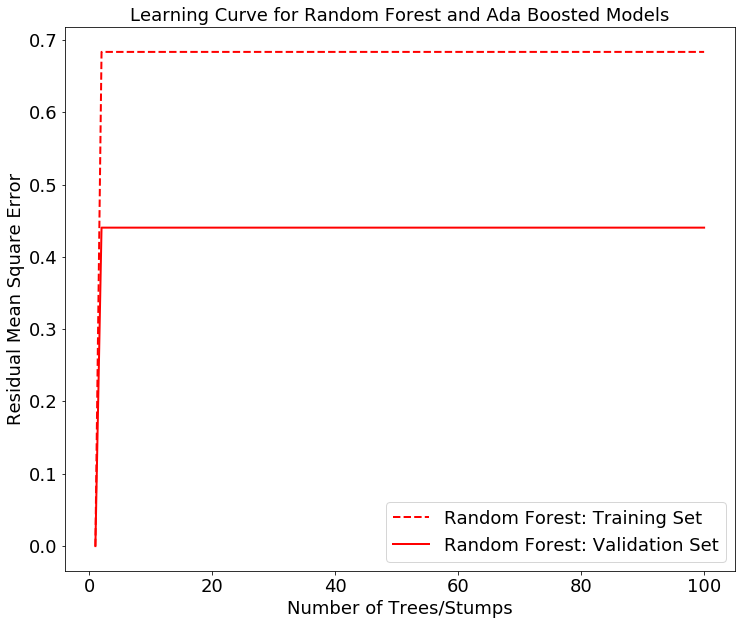

In [347]:
# Create a learning curve to see what tree values work best

fig = plt.figure(figsize = [12, 10])
ax  = fig.add_subplot(1, 1, 1)

ax.set_title('Learning Curve for Random Forest and Ada Boosted Models', fontsize = 18)

ax.plot(n_trees, RSE_train_forest, 'r--', linewidth = 2, label = 'Random Forest: Training Set')
ax.plot(n_trees, RSE_val_forest, 'r-', linewidth = 2, label = 'Random Forest: Validation Set')

#ax.plot(n_stumps, RSE_train_boost, 'b--', linewidth = 2, label = 'Ada Boosted: Training Set')
#ax.plot(n_stumps, RSE_val_boost, 'b-', linewidth = 2, label = 'Ada Boosted: Validation Set')

ax.legend(loc = 'best', fontsize = 18)

ax.set_ylabel('Residual Mean Square Error', fontsize = 18)
ax.set_xlabel('Number of Trees/Stumps', fontsize = 18)

for i in ax.xaxis.get_ticklabels() + ax.yaxis.get_ticklabels():
    i.set_size(18)
    
plt.show(block = False)
#plt.savefig(../Figures/EnsembleLearningCurve.png)


In [26]:
# Based on the figure, RSE leveled out after 20 trees. Create a model using this.
RandomForest = RandomForestTrain(x_train_val, y_train_val, attributes, max_depth = 5, multiplier = multiplier, n_trees = 50)

# Make some predictions with the new model
rf_yhat, rf_P_pos, rf_P_neg = RandomForestPredict(RandomForest, x_test, attributes, 50)

# Also based on the figure, # stumps seemed optimal for the boosted model. Create a model using this.
yhat, P_pos, P_neg, ab_yhat, ab_P_pos, ab_P_neg = AdaBoostTrain(x_train_val, y_train_val, attributes, max_depth = 1, multiplier = multiplier, n_stumps = 20, 
                                                                val = True, x_val = x_test)

In [ ]:
# Create a range of critical probability thresholds to test the models

# Note, this code is largely reused/copy and pasted from Homework 6
M_test = y_test.size

ab_P_pos = ab_P_pos[:M_test] 

crit_thresh = np.arange(0, 1, 0.001)

# Initialize the determized matrix. Each column has the predicted test labels for model. 
# Column 1 is the decision tree, column 2 is the random forest, and column 3 is the ada boosted model
P = np.zeros((M_test, 3, crit_thresh.size))

# Initialize the true positive rate, true negative rate, accuracy, and precision
tree_TPR = np.zeros((crit_thresh.size))
rf_TPR   = np.zeros((crit_thresh.size))
ab_TPR   = np.zeros((crit_thresh.size))

tree_FPR = np.zeros((crit_thresh.size))
rf_FPR   = np.zeros((crit_thresh.size))
ab_FPR   = np.zeros((crit_thresh.size))

tree_acc = np.zeros((crit_thresh.size))
rf_acc   = np.zeros((crit_thresh.size))
ab_acc   = np.zeros((crit_thresh.size))

tree_prec = np.zeros((crit_thresh.size))
rf_prec   = np.zeros((crit_thresh.size))
ab_prec   = np.zeros((crit_thresh.size))

# Turn negative values to 0 for easier use in the following code
y_test[y_test == -1] = 0

for j, ct in enumerate(crit_thresh):
    P[:,0,j] = tree_P_pos
    P[:,1,j] = rf_P_pos
    P[:,2,j] = ab_P_pos
    
    P[P[:,0,j] > ct] = 1
    P[P[:,1,j] > ct] = 1
    P[P[:,2,j] > ct] = 1
    
    # Next, calculate the values of the confusion matrix for each model
    tree_TP = np.nansum((P[:,0,j] == 1) & (y_test == 1)) # Decision tree true positives
    tree_TN = np.nansum((P[:,0,j] == 0) & (y_test == 0)) # Decision tree true positives
    tree_FP = np.nansum((P[:,0,j] == 1) & (y_test == 0)) # Decision tree false positive
    tree_FN = np.nansum((P[:,0,j] == 0) & (y_test == 1)) # Decision tree false negative
    
    rf_TP = np.nansum((P[:,1,j] == 1) & (y_test == 1)) # Random forest true positives
    rf_TN = np.nansum((P[:,1,j] == 0) & (y_test == 0)) # Random forest true positives
    rf_FP = np.nansum((P[:,1,j] == 1) & (y_test == 0)) # Random forest false positive
    rf_FN = np.nansum((P[:,1,j] == 0) & (y_test == 1)) # Random forest false negative
    
    ab_TP = np.nansum((P[:,2,j] == 1) & (y_test == 1)) # Boosted model true positives
    ab_TN = np.nansum((P[:,2,j] == 0) & (y_test == 0)) # Boosted model true positives
    ab_FP = np.nansum((P[:,2,j] == 1) & (y_test == 0)) # Boosted model false positive
    ab_FN = np.nansum((P[:,2,j] == 0) & (y_test == 1)) # Boosted model false negative
    
    # Next calculate the true positive rate
    tree_TPR[j] = tree_TP/(tree_TP + tree_FN)
    rf_TPR[j] = rf_TP/(rf_TP + rf_FN)
    ab_TPR[j] = ab_TP/(ab_TP + ab_FN)
    
    # Calculate the true negative rate
    tree_FPR[j] = 1 - tree_FP/(tree_FP + tree_FP)
    rf_FPR[j] = 1 - rf_FP/(rf_FP + rf_FP)
    ab_FPR[j] = 1 - ab_FP/(ab_FP + ab_FP)
    
    # Calculate the accuracy
    tree_acc[j] = (tree_TP + tree_TN)/(tree_TP + tree_TN + tree_FP + tree_FN)
    rf_acc[j]   = (rf_TP + rf_TN)/(rf_TP + rf_TN + rf_FP + rf_FN)
    ab_acc[j]   = (ab_TP + ab_TN)/(ab_TP + ab_TN + ab_FP + ab_FN)
    
    # Calculate the precision
    tree_prec[j] = tree_TP/(tree_TP + tree_FP)
    rf_prec[j] = rf_TP/(rf_TP + rf_FP)
    ab_prec[j] = ab_TP/(ab_TP + ab_FP)

In [ ]:
# Create a ROC curve to test how the models performed
fig = plt.figure(figsize = [12, 10])
ax  = fig.add_subplot(1, 1, 1)

ax.set_title('Reciever Operating characteristic Curve for a Tree and Tree Base Ensembles', fontsize = 20)

ax.plot(tree_FPR, tree_TPR, 'k-', linewidth = 2, label = 'Decision Tree')
ax.plot(rf_FPR, rf_TPR, 'r-', linewidth = 2, label = 'Random Forest')
ax.plot(ab_FPR, ab_TPR, 'b-', linewidth = 2, label = 'Ada Boosted Model')
ax.plot([0,1], [0,1], color = 'grey', linestyle = '--', linewidth = 2.0, label = 'Random Predictor')

ax.legend(loc = 'best', fontsize = 20)

ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])

ax.set_xlabel('False Positive Rate', fontsize = 18)
ax.set_ylabel('True Positive Rate', fontsize = 18)

for i in ax.xaxis.get_ticklabels() + ax.yaxis.get_ticklabels():
    i.set_size(18)
    
plt.show(block = False)
#plt.savefig('../Figures/EnsemblesROCcurve.png')

In [ ]:
# Compute some statistics to compare the models

# Restore y_test for these calculations
y_test[y_test == 0] = -1

tree_RSS = np.nansum((y_test - tree_yhat)**2)
rf_RSS   = np.nansum((y_test - rf_yhat)**2)
ab_RSS   = np.nansum((y_test - ab_yhat)**2)

TSS = np.nansum((y_test - np.nanmean(y_test))**2)

tree_sig_e = np.nanvar(y_test - tree_yhat)
rf_sig_e   = np.nanvar(y_test - rf_yhat)
ab_sig_e   = np.nanvar(y_test - ab_yhat)

# Calculate the ajdusted R^2
tree_adj_R2 = 1 - (tree_RSS/(M_test - N - 1))/(TSS/(M_test - 1))
rf_adj_R2 = 1 - (rf_RSS/(M_test - N - 1))/(TSS/(M_test - 1))
ab_adj_R2 = 1 - (ab_RSS/(M_test - N - 1))/(TSS/(M_test - 1))

# Calculate the Cp statistic
tree_Cp = 1/M_test * (tree_RSS + 2 * N * tree_sig_e)
rf_Cp = 1/M_test * (rf_RSS + 2 * N * rf_sig_e)
ab_Cp = 1/M_test * (ab_RSS + 2 * N * ab_sig_e)

# Next, calculate the Younden index
tree_youn = tree_TPR - tree_FPR
rf_youn = rf_TPR - rf_FPR
rf_youn = ab_TPR - ab_FPR

# Calculate the index of the maximum Younden value
tree_ind = np.where(tree_youden == np.max(tree_youden))[0]
rf_ind = np.where(rf_youden == np.max(rf_youden))[0]
ab_ind = np.where(ab_youden == np.max(ab_youden))[0]


In [ ]:
# Output the calculated statistics
print('The following models had the following value for adjusted R^2, Cp, max Younden index, associated accuracy, associated precision, associated probability threshold, respectively')

print('Decision Tree: %4.2f, %4.2f, %4.2f, %4.2f, %4.2f, %4.2f' %(tree_adj_R2, tree_Cp, tree_youn[tree_ind[0]], tree_acc[tree_ind[0]], tree_prec[tree_ind[0]], crit_thresh[tree_ind[0]]))
print('Random Forest: %4.2f, %4.2f, %4.2f, %4.2f, %4.2f, %4.2f' %(rf_adj_R2, rf_Cp, rf_youn[rf_ind[0]], rf_acc[rf_ind[0]], rf_prec[rf_ind[0]], crit_thresh[rf_ind[0]]))
print('Ada Boosted Model: %4.2f, %4.2f, %4.2f, %4.2f, %4.2f, %4.2f' %(ab_adj_R2, ab_Cp, ab_youn[ab_ind[0]], ab_acc[ab_ind[0]], ab_prec[ab_ind[0]], crit_thresh[ab_ind[0]]))